<span style="color:  #0a4b77; font-family: Babas; font-size: 3em;">Report on exploration of concepts</span>

<div style="text-align: right"> who worked on this document: Amelie, Renato </div>

This report is one of the sub-products of the discussions registered in [this](https://docs.google.com/document/d/1E9QCUO6kzD20H8pSXmZasA0t08KUbzFJGOae5WZdRBY/edit) document.  

Basically, we assume that we are developing user interfaces to access some kind of document (pictures, texts, reports, DB entries) in which the user will be offered relevant items as a result of his/her query.  
Traditionally, the [similarity](https://en.wikipedia.org/wiki/Similarity_measure) among a query and the documents in a particular collection is measured by some common characteristics, as the raw word frequency, in order to generate a ranking (ordering) of relevant results.  
These [semantic similarities](https://en.wikipedia.org/wiki/Semantic_similarity) can be calculated by many different algoritms, as the [Vector Space](https://en.wikipedia.org/wiki/Vector_space_model) models.  

The goal of this document is to show alternatives to enhance the similarity functions by adding semantically related documents documents to the results, even though they may not share common words.

Loading Python packages

In [1]:
import random
import time
import pickle
import sys
import json
import re
import string
import collections
import codecs
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3

from sklearn import feature_extraction

import gensim
from gensim import corpora
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords
from nltk.tag.sequential import ClassifierBasedTagger
#from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.tokenize import word_tokenize

#sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config
#sudo pip install pygraphviz
import pygraphviz 
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from pygermanet import load_germanet, Synset
from scipy.stats.stats import pearsonr

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

pd.options.mode.chained_assignment = None  # default='warn'

<span style="color: #2280c2; font-family: Babas; font-size: 2em;">Strategy #1: using the concepts in the DBO@EMA frage</span>

#### The concepts were extracted from the fragebogen(questionnaires)/frage(questions) and we have now a table that contains the lemmatized version of them. We have also separated the words considered to be auxiliary in the questions (syntactic) and the relevant concepts (semantic)

In [2]:
frage = pd.read_pickle('./frage.pickle')
frage.head(10)

fragebogen_id nummer                                     original_frage  \
0              1     A1           Kopf: Kopf, Haupt; auch scherzh./übertr.   
1              1     A2  Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...   
2              1     A3  Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...   
3              1     A4  Kopf: schöner, ebenmäßig gebauter Kopf (Christ...   
4              1    A4a                Kopf: häßlicher, unebenmäßiger Kopf   
5              1     A5                      Kopf: großer Kopf; großkopfig   
6              1    A5a                                   Kopf: Wasserkopf   
7              1     A6                                 Kopf: kleiner Kopf   
8              1     A7                       Kopf: oben zugespitzter Kopf   
9              1     A8                                  Kopf: langer Kopf   

  main_theme                                     question_words  \
0     [kopf]              [haupt, scherzhaft, übertragen, kopf]   
1     [kopf]  [vergleich, ursprünglich, bedeutung, haupt, ko...   
2     [kopf]  [vergleich, verdrehen, jemand, offen, kopf, ha...   
3     [kopf]  [tituskopf, gebaut, ebenmäßig, kopf, schön, ch...   
4     [kopf]                       [häßlich, unebenmäßig, kopf]   
5     [kopf]                           [groß, großkopfig, kopf]   
6     [kopf]                                 [wasserkopf, kopf]   
7     [kopf]                                      [klein, kopf]   
8     [kopf]                           [oben, zugespitzt, kopf]   
9     [kopf]                                       [lang, kopf]   

                                      semantic_words  \
0                                      [haupt, kopf]   
1  [vergleich, ursprünglich, haupt, kopf, möchten...   
2  [vergleich, verdrehen, jemand, offen, kopf, ha...   
3  [tituskopf, gebaut, ebenmäßig, kopf, schön, ch...   
4                       [häßlich, unebenmäßig, kopf]   
5                           [groß, großkopfig, kopf]   
6                                 [wasserkopf, kopf]   
7                                      [klein, kopf]   
8                           [oben, zugespitzt, kopf]   
9                                       [lang, kopf]   

             syntactic_words                                     NN  \
0   [scherzhaft, übertragen]                          [haupt, kopf]   
1   [bedeutung, redensarten]  [vergleich, haupt, kopf, zerspringen]   
2  [redensarten, übertragen]    [vergleich, verdrehen, kopf, haupt]   
3                         []        [tituskopf, kopf, christuskopf]   
4                         []                                 [kopf]   
5                         []                                 [kopf]   
6                         []                     [wasserkopf, kopf]   
7                         []                          [klein, kopf]   
8                         []                     [zugespitzt, kopf]   
9                         []                                 [kopf]   

                  VB                     ADJ  
0                 []                      []  
1  [möchten, stehen]          [ursprünglich]  
2                 []           [offen, fein]  
3                 []      [ebenmäßig, schön]  
4                 []  [häßlich, unebenmäßig]  
5                 []      [groß, großkopfig]  
6                 []                      []  
7                 []                 [klein]  
8                 []                      []  
9                 []                  [lang]

#### We can, for example, examine the words that co-occur in specific frage(questions) in a given fragebogen(questionnaires), as the graph below illustrates:

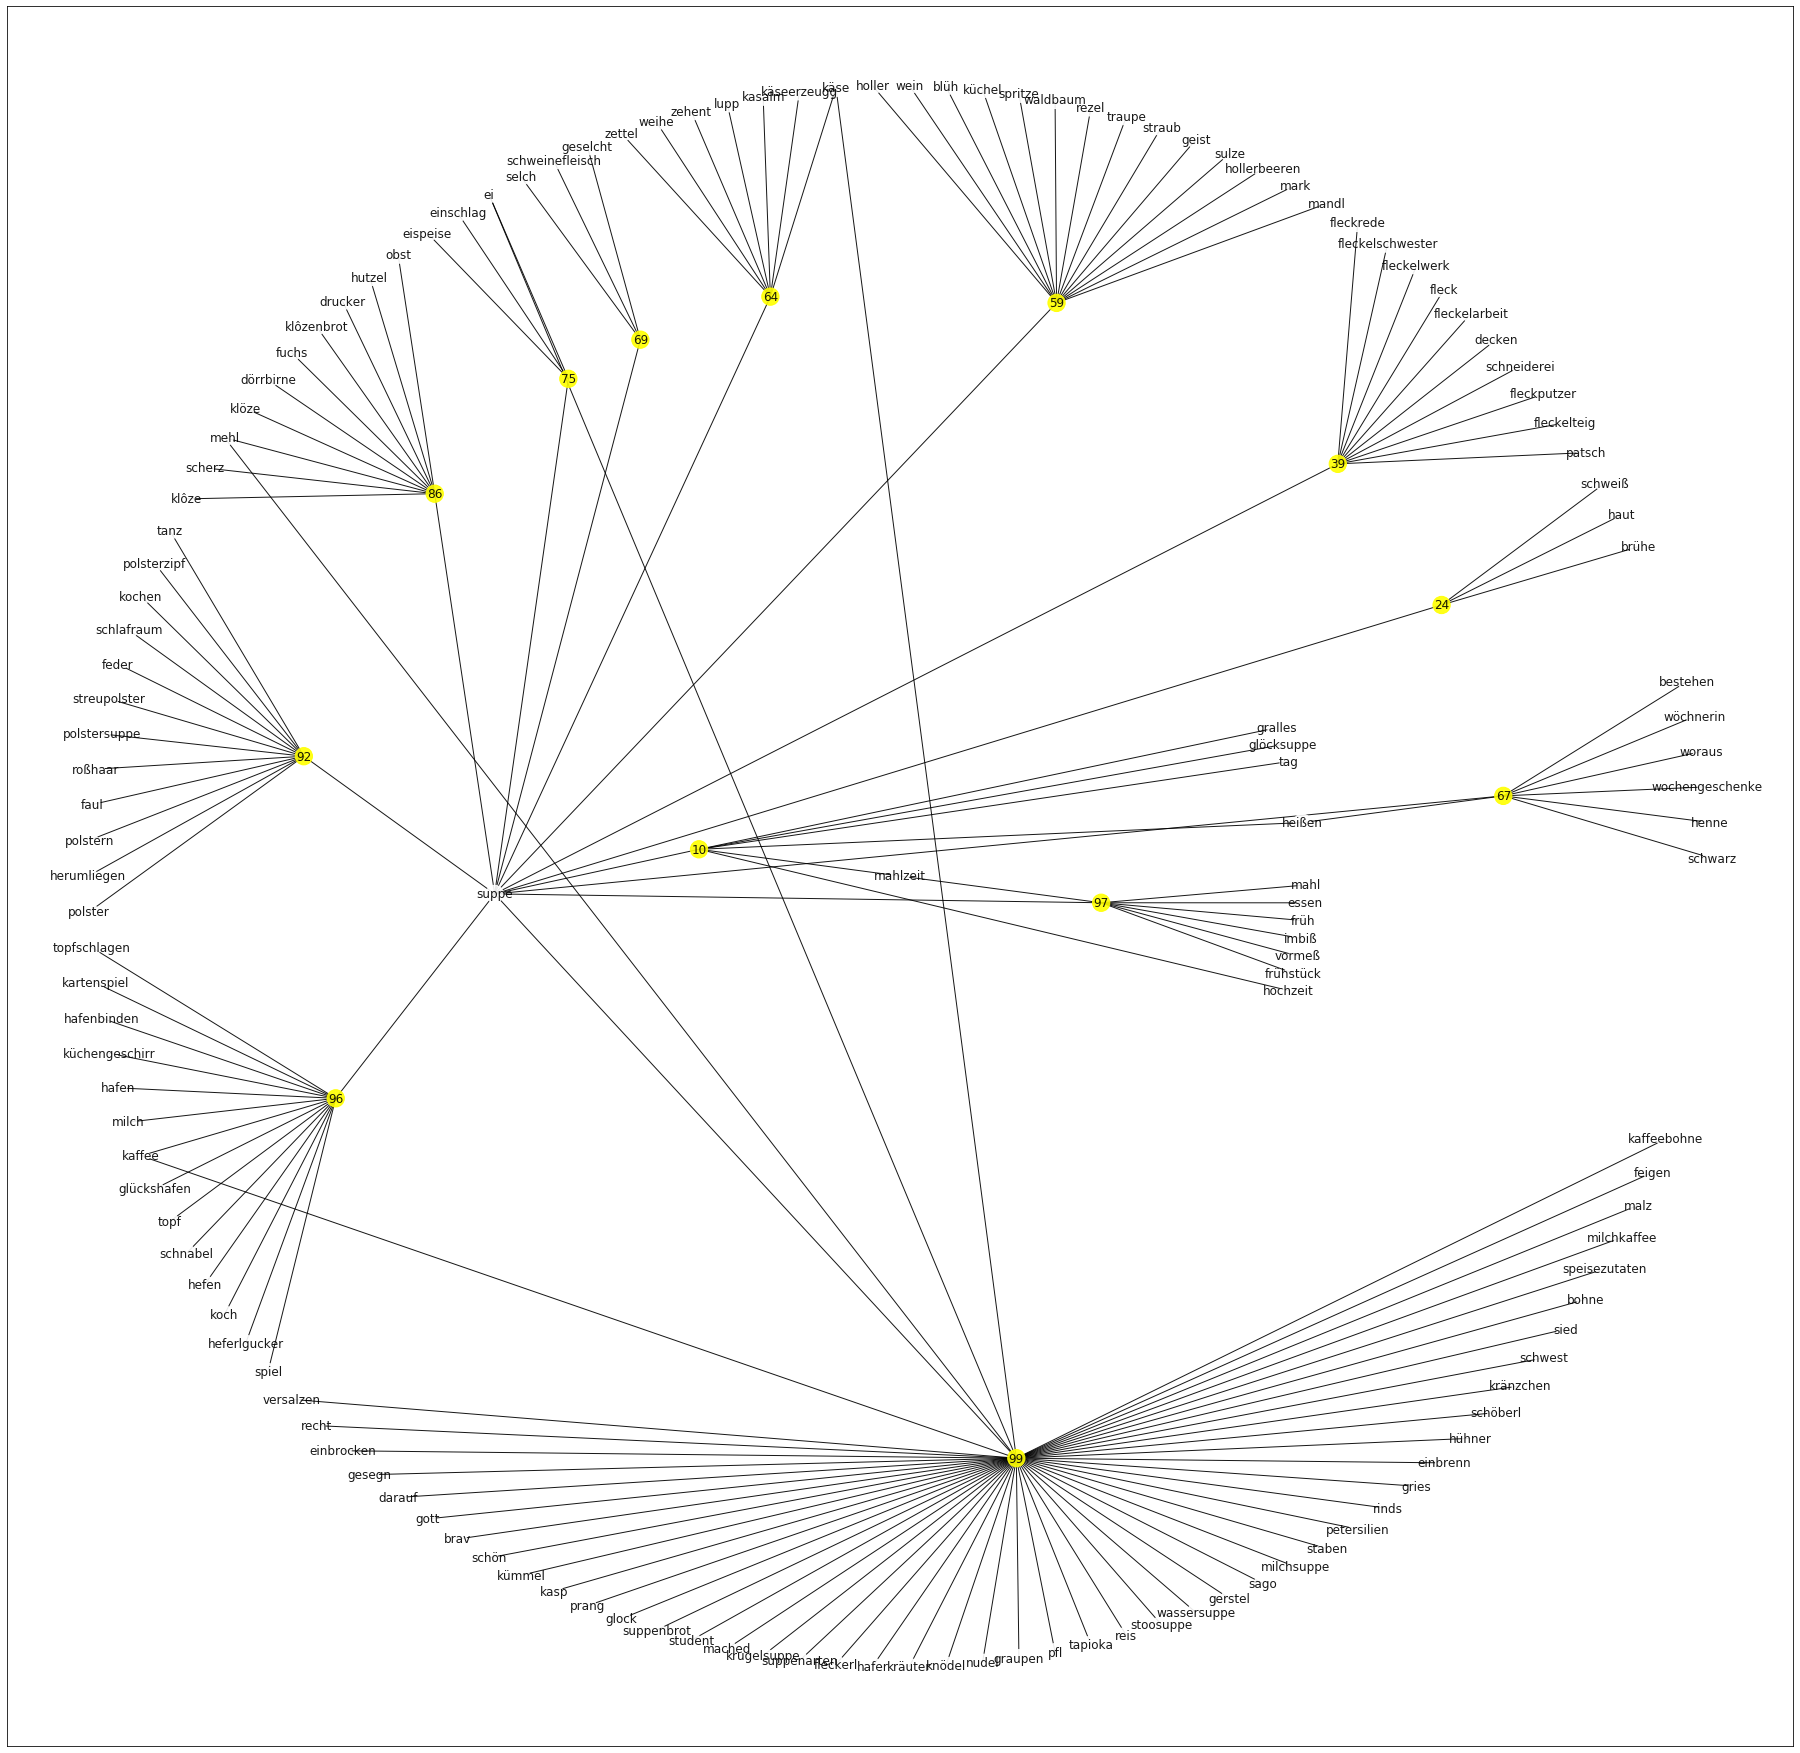

In [3]:
#cfilter = "kopf"
#cfilter = "schwarz"
cfilter = "suppe"
#cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)
        
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 width=1,
                 alpha=0.9,
                 #cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

plt.savefig('./outputs/{}_report1.png'.format(cfilter), bbox_inches='tight')

#### These co-ocurring words could be used for finding no explicit similarities based in our collection.  

#### Another way to explore our collection would be to create a [word embedding/Word2vec](https://skymind.ai/wiki/word2vec) model based in our collection, to check with words are similar to other ones. That would generate a vector space in which similar words could be found, based on their contexts of ocurrence.  

In [4]:
sentences = []
for sentence in frage.semantic_words.values:
    sentences.append(sentence)

our_model = gensim.models.Word2Vec(sentences, min_count=1)

In [5]:
words = ['blau', 'rot', 'kopf']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in our_model.wv.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: blau
('ähnlich', 0.7444924116134644)
('kommen', 0.7425953149795532)
('führen', 0.7381731271743774)
('schneiderei', 0.7349293828010559)
('schiffahrt', 0.7329698204994202)
('gewerbe', 0.7329250574111938)
('besonderer', 0.7325437068939209)
('mensch', 0.7321563959121704)
('fleisch', 0.7275329828262329)
('brot', 0.7254607677459717)
('heißen', 0.7244822978973389)
('art', 0.7233986854553223)
('teil', 0.7223628759384155)
('dergleichen', 0.7214140892028809)
('verwendung', 0.7191422581672668)
('bauer', 0.7190819978713989)
('sonstig', 0.7185332775115967)
('gehen', 0.717758297920227)
('heu', 0.716474711894989)
('vogel', 0.7150721549987793)

word: rot
('kopf', 0.8256436586380005)
('ähnlich', 0.8206092119216919)
('gewerbe', 0.8197307586669922)
('gehen', 0.8145105242729187)
('baum', 0.8139464855194092)
('gut', 0.8125354051589966)
('besonderer', 0.8073568344116211)
('bauer', 0.805289626121521)
('brot', 0.8022690415382385)
('art', 0.8018685579299927)
('sonstig', 0.8009614944458008)
('form', 0.79

#### This word2vec model was created from our small corpus. That is, the frage/questions are the contexts that will generate the words similarity, but instead of a direct association, as we have in the graph above, we would have a function that yield the similarity of any pair of words.  

#### Other properties could also be explored, as the geometry of the vectorial space, to find similarities by analogy.  

In [6]:
def draw_words(model, words, pca=False, alternate=True, arrows=True, x1=3, x2=3, y1=3, y2=3, title=''):
    # get vectors for given words from model
    vectors = [model.wv[word] for word in words]
    if pca:
        pca = PCA(n_components=2, whiten=True)
        vectors2d = pca.fit(vectors).transform(vectors)
    else:
        tsne = TSNE(n_components=2, random_state=0)
        vectors2d = tsne.fit_transform(vectors)

    # draw image
    plt.figure(figsize=(6,6))
    if pca:
        plt.axis([x1, x2, y1, y2])

    first = True # color alternation to divide given groups
    for point, word in zip(vectors2d , words):
        # plot points
        plt.scatter(point[0], point[1], c='r' if first else 'g')
        # plot word annotations
        plt.annotate(
            word, 
            xy = (point[0], point[1]),
            xytext = (-7, -6) if first else (7, -6),
            textcoords = 'offset points',
            ha = 'right' if first else 'left',
            va = 'bottom',
            size = "x-large"
        )
        first = not first if alternate else first

    # draw arrows
    if arrows:
        for i in range(0, len(words)-1, 2):
            a = vectors2d[i][0] + 0.04
            b = vectors2d[i][1]
            c = vectors2d[i+1][0] - 0.04
            d = vectors2d[i+1][1]
            plt.arrow(a, b, c-a, d-b,
                shape='full',
                lw=0.1,
                edgecolor='#bbbbbb',
                facecolor='#bbbbbb',
                length_includes_head=True,
                head_width=0.08,
                width=0.01
            )

    # draw diagram title
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

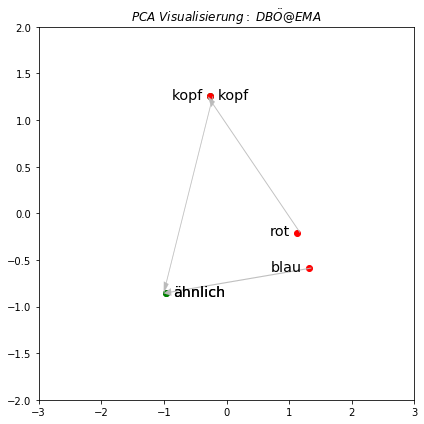

In [21]:
words = ["rot",
         "kopf",
         'blau',
         'ähnlich',
         'kopf',
         'ähnlich' ]

draw_words(our_model, words, True, True, True, -3, 3, -2, 2, r'$PCA\ Visualisierung:\ DB\ddot{O}@EMA$')

In [8]:
for result in our_model.wv.most_similar(positive=['frau', 'blau'], negative=['mann']):
    print(result)

('reden', 0.586450457572937)
('schiffahrt', 0.5817582607269287)
('gruß', 0.5693921446800232)
('fleisch', 0.567436695098877)
('schneiderei', 0.565645694732666)
('mensch', 0.5628502368927002)
('hautkrankh', 0.5617960691452026)
('gewerbe', 0.5609207153320312)
('weinbau', 0.5583462715148926)
('volksglaube', 0.5572456121444702)


#### Using our model to expand the similarities graph

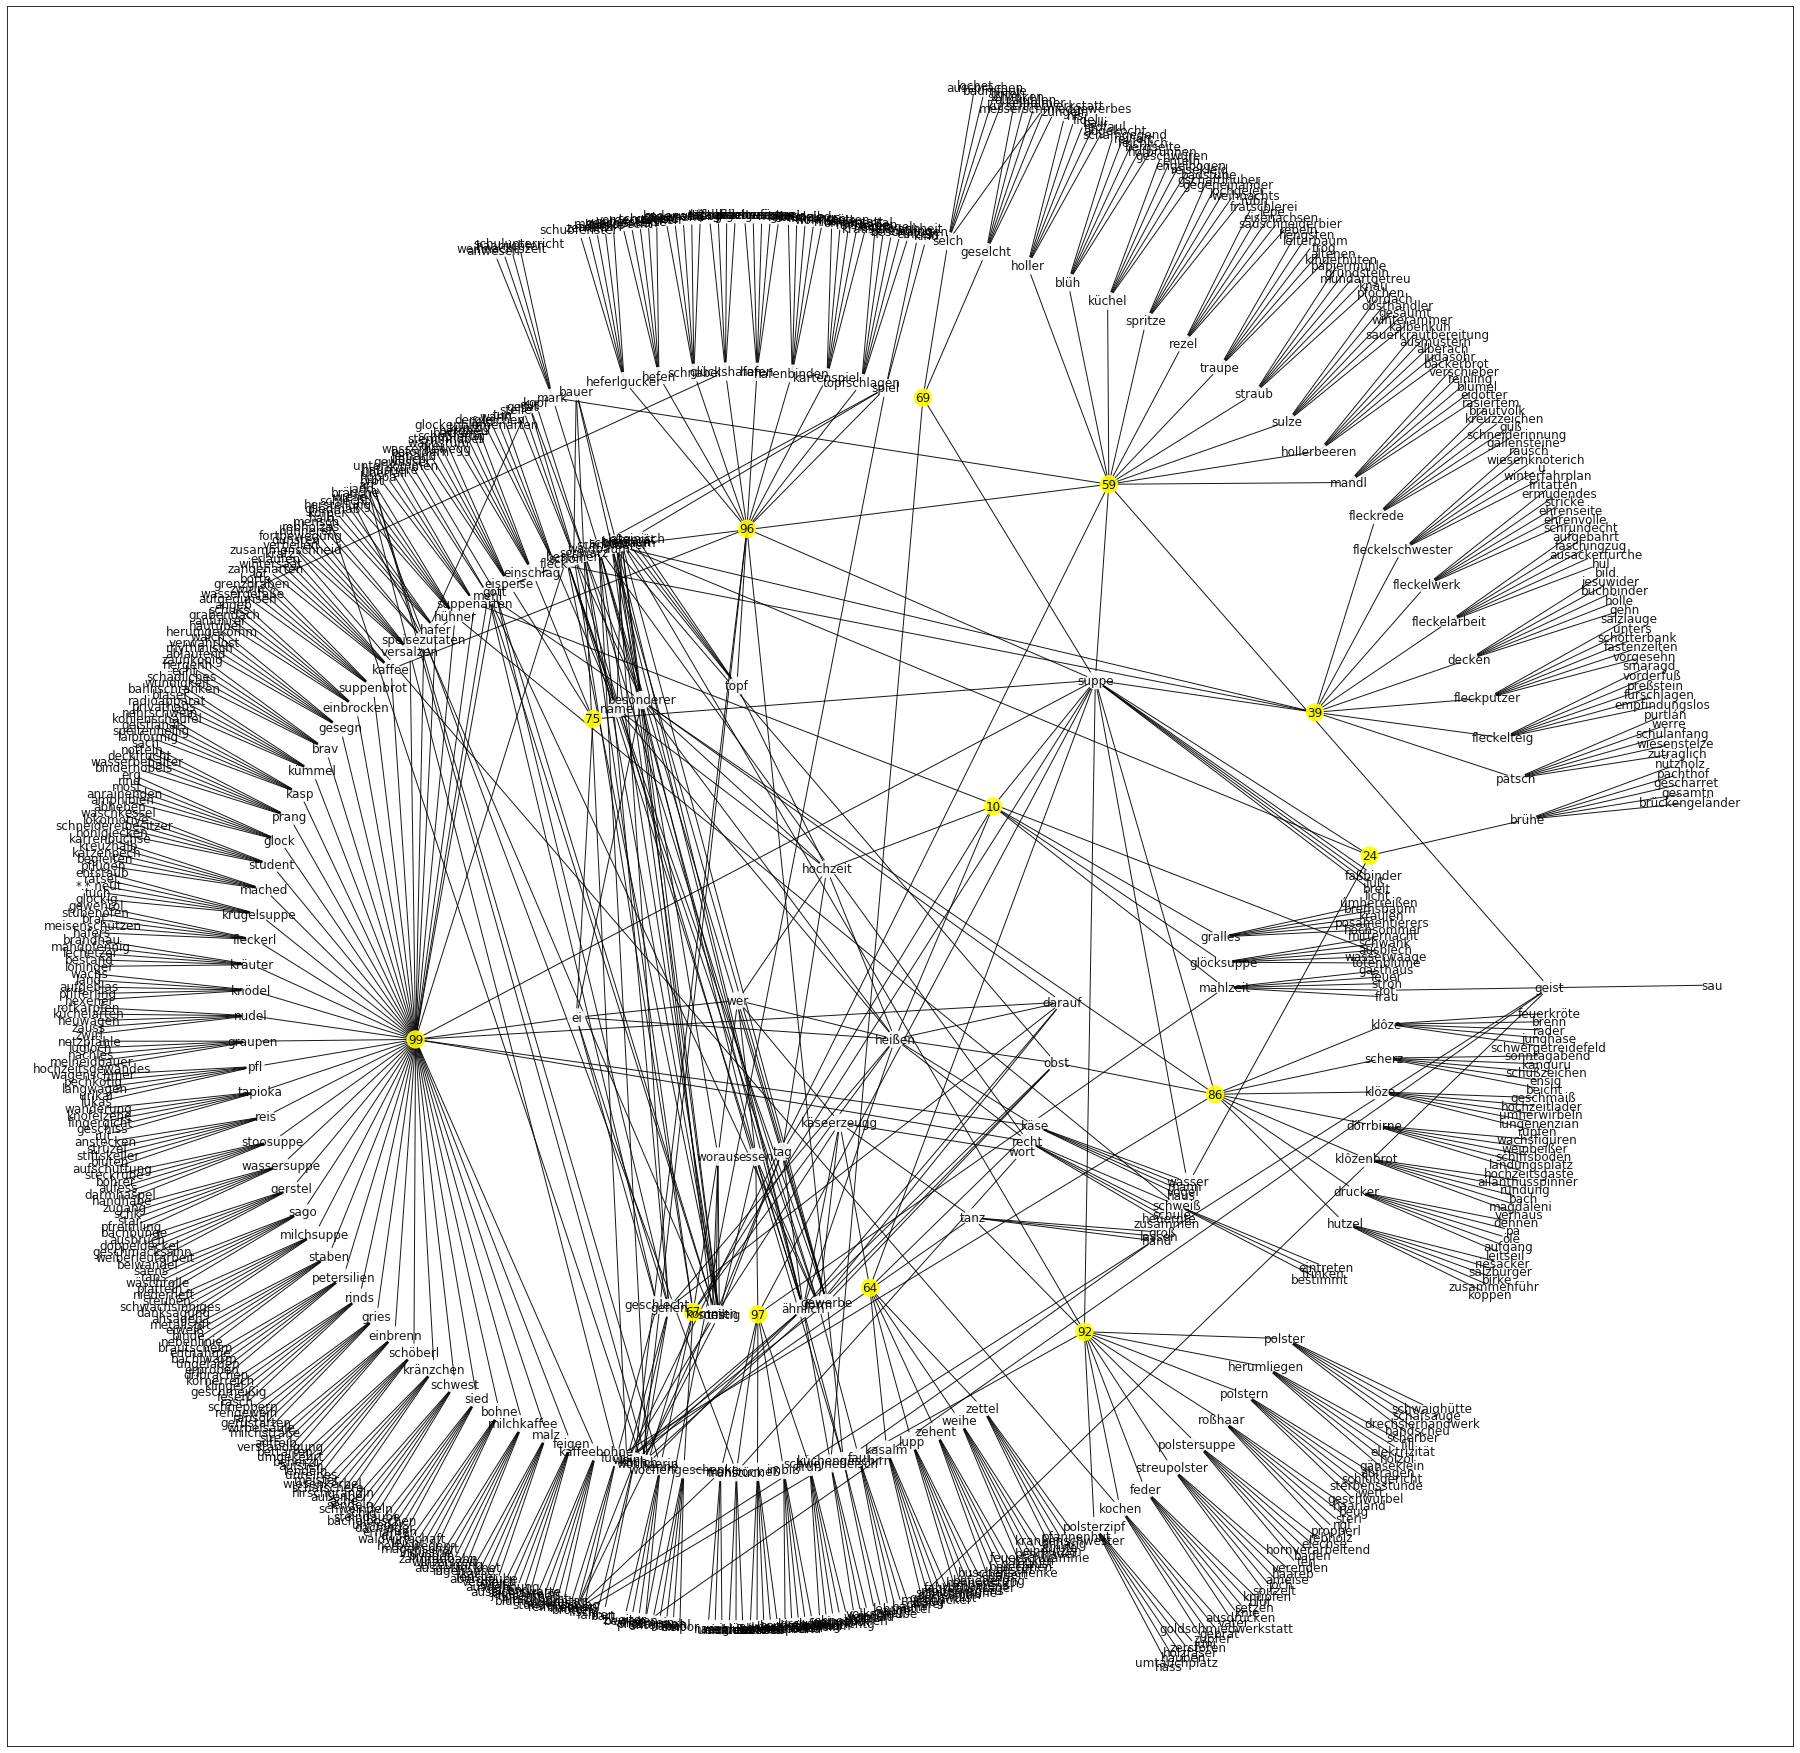

In [9]:
#cfilter = "kopf"
#cfilter = "schwarz"
cfilter = "suppe"
#cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        for w in our_model.wv.most_similar(concept, topn=5):
            G.add_node(w[0], color='white')
            G.add_edge(concept, w[0], length = 10)        
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)
        
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 width=1,
                 alpha=0.9,
                 cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

plt.savefig('./outputs/{}_report2.png'.format(cfilter), bbox_inches='tight')

<span style="color: #2280c2; font-family: Babas; font-size: 2em;">Strategy #2: using the concepts in the wikipedia</span>

Besides using our own embeddings model, we can have alternate results for the same queries using another pre-trained model (as this one, below, trained with tokens and bigrams from the wikipedia)  

In [10]:
trained_model = gensim.models.KeyedVectors.load_word2vec_format('../../nlp/German_Word2vec/german.model', binary=True)
trained_model.init_sims(replace=True)

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [11]:
words = ['blau', 'rot', 'kopf']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in trained_model.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: blau
('rot', 0.8281903862953186)
('gruen', 0.7959476709365845)
('gelb', 0.7838804721832275)
('orange', 0.7746740579605103)
('grau', 0.7626761198043823)
('Blau', 0.7593175172805786)
('schwarz', 0.755070149898529)
('braun', 0.7448124885559082)
('tuerkis', 0.7368776202201843)
('rosa', 0.7332463264465332)
('lila', 0.7257266640663147)
('rot_gelb', 0.7144009470939636)
('Hellblau', 0.7142020463943481)
('gelb_blau', 0.7131950855255127)
('blau_rot', 0.7092214822769165)
('dunkelblau', 0.707565188407898)
('Gelb_Orange', 0.7064606547355652)
('pink', 0.7047414779663086)
('weiss_rot', 0.7010555267333984)
('rot_blau', 0.6987532377243042)

word: rot
('gelb', 0.8350189924240112)
('gruen', 0.8290626406669617)
('blau', 0.8281903266906738)
('schwarz', 0.7826082706451416)
('orange', 0.7713059186935425)
('grau', 0.7314903736114502)
('rot_gelb', 0.7234443426132202)
('rote', 0.7225121259689331)
('braun', 0.7214125990867615)
('lila', 0.7197442650794983)
('violett', 0.7078529596328735)
('Blau', 0.7019246

In [12]:
for result in trained_model.most_similar(positive=['frau', 'blau'], negative=['mann']):
    print(result)

('rosa', 0.6545881032943726)
('orange', 0.6302927732467651)
('gruen', 0.619945764541626)
('rot', 0.619027316570282)
('Glitzer', 0.6155712604522705)
('lila', 0.6148803234100342)
('grau', 0.6142277717590332)
('pink', 0.6076772212982178)
('knallrot', 0.6024129390716553)
('knallige_Farben', 0.5976543426513672)


In [13]:
for result in trained_model.most_similar(positive=['frauen'], negative=['mann']):
    print(result)

('Schuleinrichtungen', 0.33441242575645447)
('Kulturelle_Einrichtungen', 0.33263546228408813)
('karitative_Projekte', 0.3285147249698639)
('Unterstuetzungsaufgaben', 0.32629942893981934)
('Behandlungszentren', 0.32239392399787903)
('Lending', 0.3211556375026703)
('Verkaufsaktionen', 0.3200957477092743)
('Wohltaetigkeitsorganisationen', 0.3181988596916199)
('sportliche_kulturelle', 0.3169676661491394)
('beduerftige_Kinder', 0.31420350074768066)


/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use s

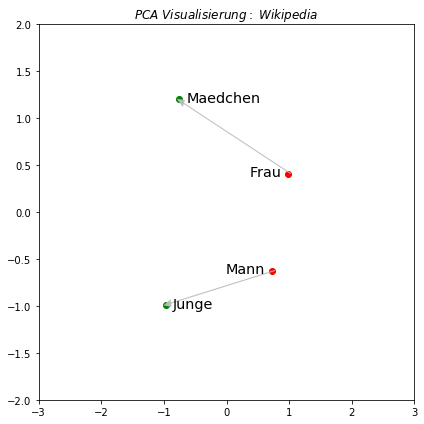

In [14]:
words = ['Mann',
         'Junge',
         'Frau',
         'Maedchen',
        ]

draw_words(trained_model, words, True, True, True, -3, 3, -2, 2, r'$PCA\ Visualisierung:\ Wikipedia$')

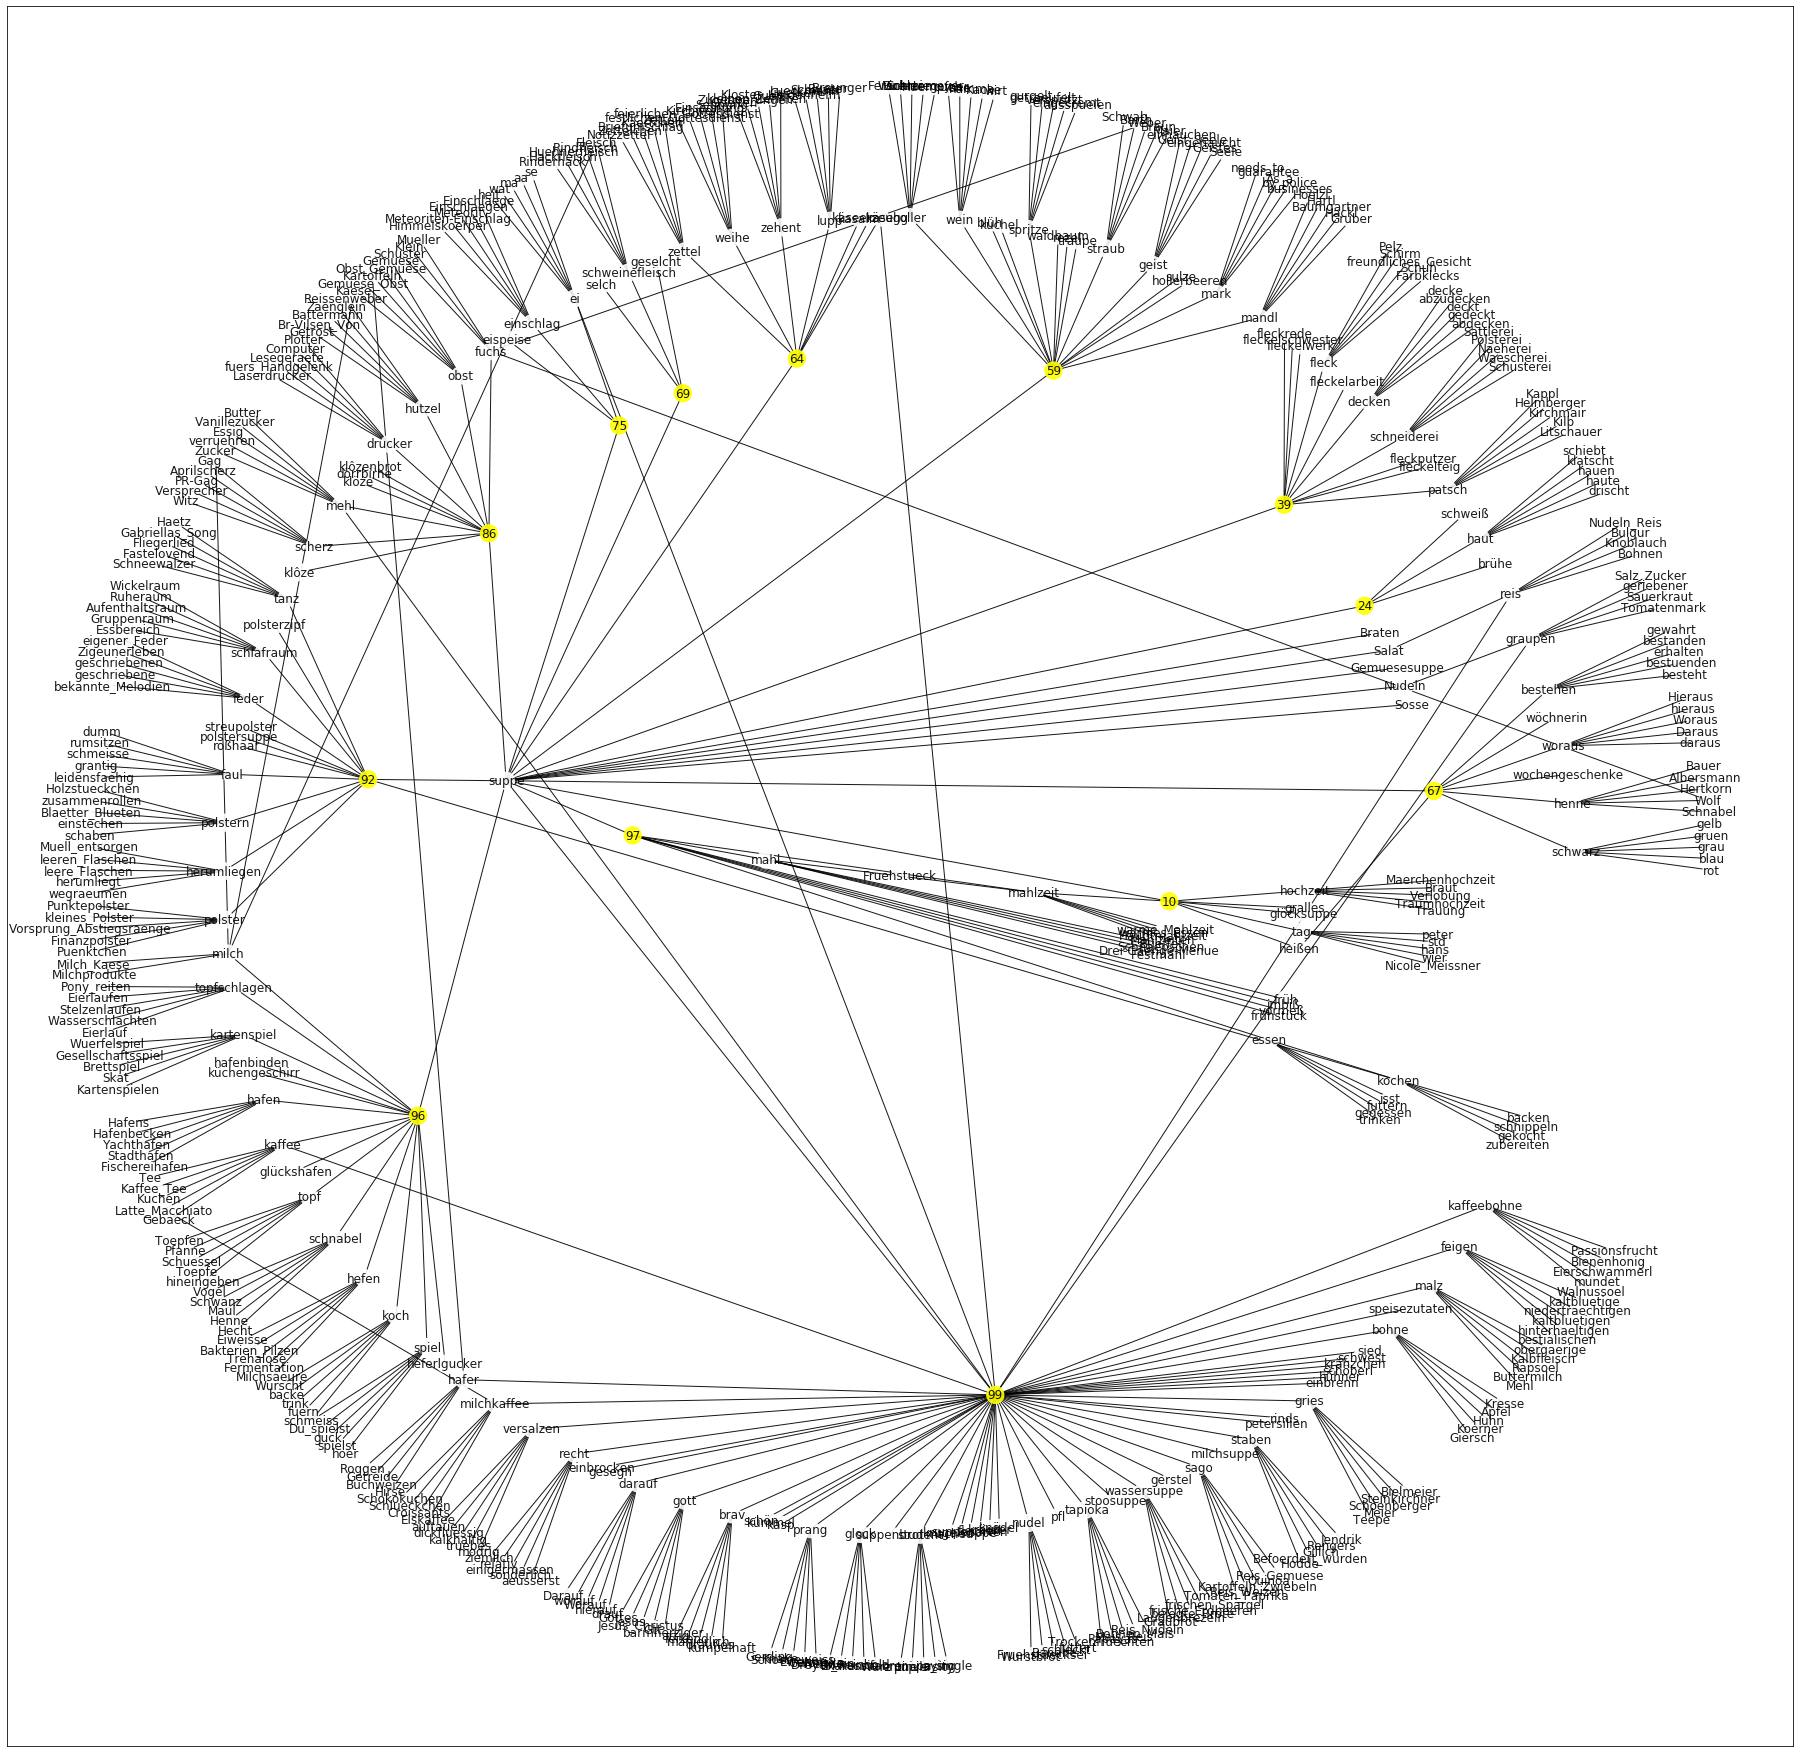

In [15]:
#cfilter = "kopf"
#cfilter = "schwarz"
cfilter = "suppe"
#cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        try:
            similar = trained_model.most_similar(concept, topn=5)
        except:
            try:
                similar = trained_model.most_similar(concept.title(), topn=5)
            except:
                similar = None
        if similar:
            for w in similar:
                G.add_node(w[0], color='white')
                G.add_edge(concept, w[0], length = 10)        
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)
        
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 width=1,
                 alpha=0.9,
                 cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

plt.savefig('./outputs/{}_report3.png'.format(cfilter), bbox_inches='tight')

<span style="color: #2280c2; font-family: Babas; font-size: 2em;">Strategy #3: using the Germanet Synsets</span>

In [16]:
gn = load_germanet()

#### Testing the coverage of the collection in the Germanet

In [17]:
concepts = {}
concepts_covered = {}
for concept_list in frage.semantic_words:
    for concept in concept_list:
        if concept in concepts:
            concepts[concept] += 1
        else:
            concepts[concept] = 1
        try:
            lem = gn.lemmatise(concept)[0]
            syn = gn.synsets(lem)
            if not syn:
                syn = gn.synsets(lem.title())
            if syn and (concept not in concepts_covered):
                concepts_covered[concept] = len(syn)
        except:
            print('fail on lemma: {}'.format(lem))

print('the total number of concepts in the collection is: {}'.format(len(concepts)))
print('the total number of concepts in the collection covered by Germanet is: {}'.format(len(concepts_covered)))
coverage = len(concepts_covered)/len(concepts)
print('the percentage of coverage is: {:.2%}'.format(coverage))

the total number of concepts in the collection is: 31262
the total number of concepts in the collection covered by Germanet is: 11718
the percentage of coverage is: 37.48%


Examples of concepts not covered:

In [18]:
[k for k,v in concepts.items() if k not in concepts_covered][0:20]

['jemand',
 'fein',
 'tituskopf',
 'christuskopf',
 'häßlich',
 'unebenmäßig',
 'großkopfig',
 'oben',
 'mißgestalteter',
 'hasenkopf',
 'behafteen',
 'nißkopf',
 'kopfes',
 'grindkopf',
 'krätzen',
 'schädeln',
 'enthaupt',
 'weiberkopf',
 'wiedereingraben',
 'bräuche']

#### Example on exploration of synsets

In [19]:
word = 'Suppe'
#word = 'falb'
#word = 'Kopf'

lem = gn.lemmatise(word)[0]
print("concept: {}, lemma: {} ".format(word, lem))
print()
syn = gn.synsets(lem)
if not syn:
    syn = gn.synsets(lem.title()) #[0]
else:
    syn = gn.synsets(lem) #[0]
for s in syn:
    print("synset: ", s)
    print()
    for lemma in s.lemmas:
        print('\t- {}'.format(lemma.orthForm))
    print()    
    for hypo in s.hyponyms:
        print('\thyponym: {}'.format(hypo))
    print()
    for hyper in s.hypernyms:
        print('\thypernym: {}'.format(hyper))
        print()
    print('\tgeneric class: {}'.format(s.gn_class))
    print()
print()

concept: Suppe, lemma: Suppe 

synset:  Synset(Suppe.n.1)

	- Suppe

	hyponym: Synset(Mehlsuppe.n.1)
	hyponym: Synset(Krebssuppe.n.1)
	hyponym: Synset(Wurstsuppe.n.1)
	hyponym: Synset(Tomatensuppe.n.1)
	hyponym: Synset(Blumenkohlsuppe.n.1)
	hyponym: Synset(Fischsuppe.n.1)
	hyponym: Synset(Krabbensuppe.n.1)
	hyponym: Synset(Milchsuppe.n.1)
	hyponym: Synset(Lauchcremesuppe.n.1)
	hyponym: Synset(Mexikanische Bohnensuppe.n.1)
	hyponym: Synset(Graupensuppe.n.1)
	hyponym: Synset(Kohlsuppe.n.1)
	hyponym: Synset(Nudelsuppe.n.1)
	hyponym: Synset(Rahmsuppe.n.1)
	hyponym: Synset(Rindfleischsuppe.n.1)
	hyponym: Synset(Möhrensuppe.n.1)
	hyponym: Synset(Schleimsuppe.n.1)
	hyponym: Synset(Tagessuppe.n.1)
	hyponym: Synset(Kräutersuppe.n.1)
	hyponym: Synset(Wassersuppe.n.1)
	hyponym: Synset(Markklößchensuppe.n.1)
	hyponym: Synset(Brühe.n.1)
	hyponym: Synset(Hochzeitssuppe.n.1)
	hyponym: Synset(Kürbissuppe.n.1)
	hyponym: Synset(Schildkrötensuppe.n.1)
	hyponym: Synset(Rindsuppe.n.1)
	hyponym: Synset(Dose

#### Example on concept synonyms (blue), hyponyms (yellow), hypernyms (orange) and generic class (pink)

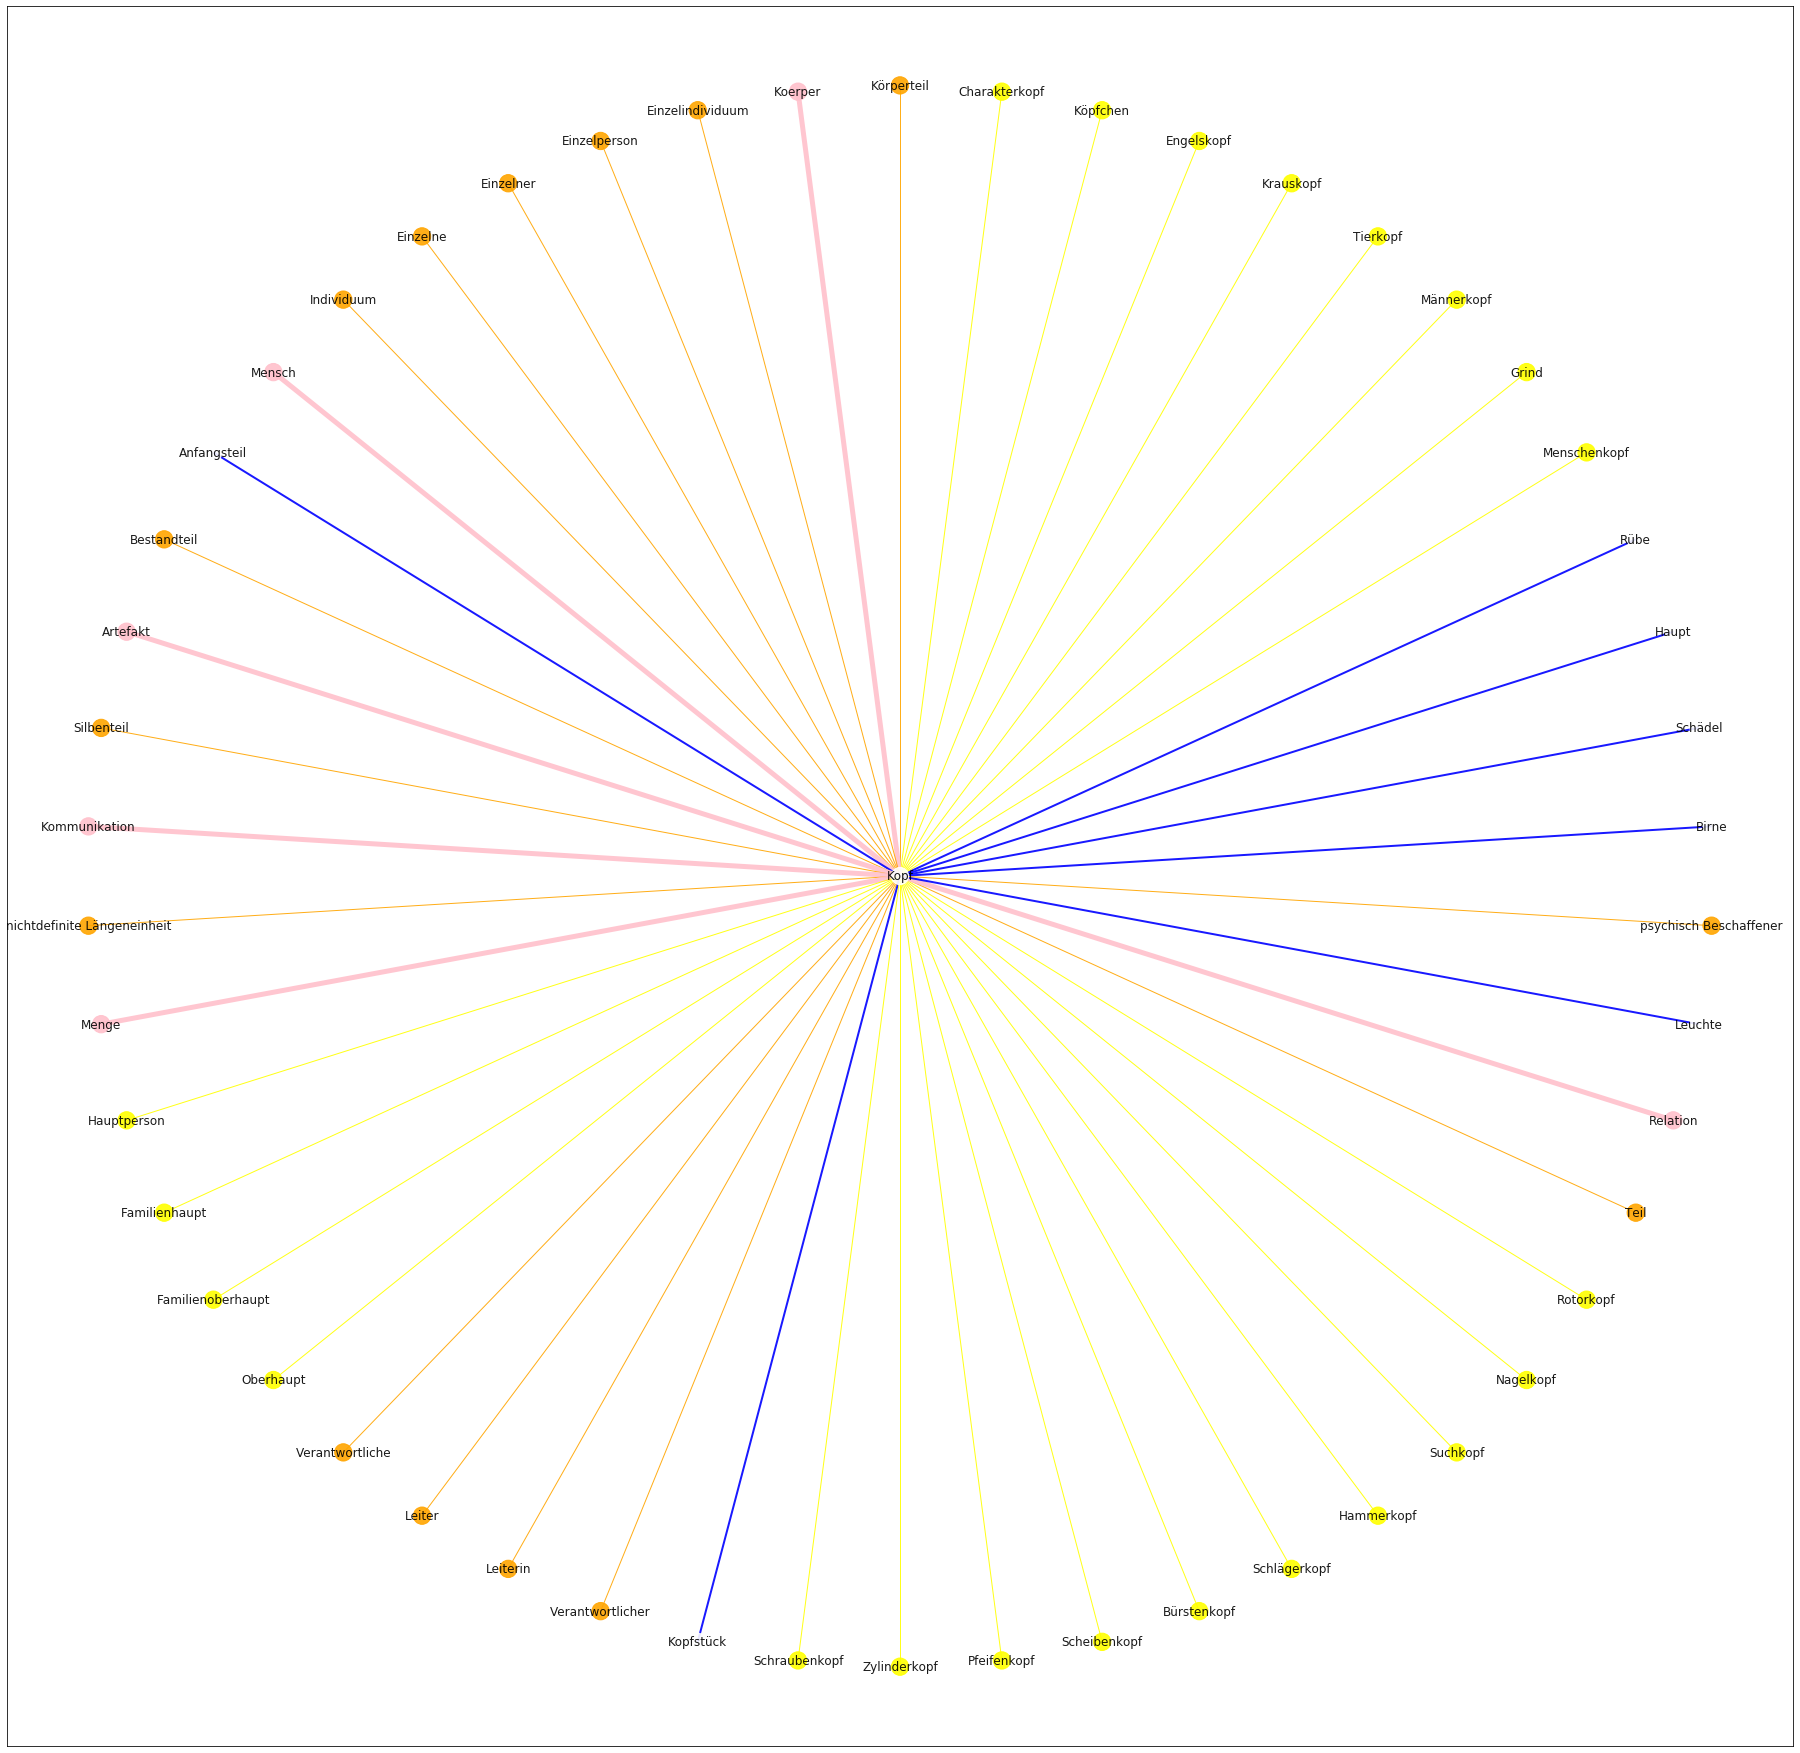

In [20]:
#word = 'Suppe'
#word = 'falb'
word = 'Kopf'

G = nx.Graph()

lem = gn.lemmatise(word)[0]
G.add_node(lem, color='white')

syn = gn.synsets(lem)
if not syn:
    syn = gn.synsets(lem.title()) #[0]
else:
    syn = gn.synsets(lem) #[0]

for s in syn:
    #print("synset: ", s)
    for lemma in s.lemmas:
        #print('\t- {}'.format(lemma.orthForm))
        G.add_node(lemma.orthForm, color='white')
        G.add_edge(lem, lemma.orthForm, color='blue', weight=2, length = 5)        
    for hypo in s.hyponyms:
        #print('\thyponym: {}'.format(hypo))
        for lemma in hypo.lemmas:
            #print('\t- {}'.format(lemma.orthForm))
            G.add_node(lemma.orthForm, color='yellow')
            G.add_edge(lem, lemma.orthForm, color='yellow', weight=1,length = 10)   
    for hyper in s.hypernyms:
        #print('\thypernym: {}'.format(hyper))
        for lemma in hyper.lemmas:
            #print('\t- {}'.format(lemma.orthForm))
            G.add_node(lemma.orthForm, color='orange')
            G.add_edge(lem, lemma.orthForm, color='orange', weight=1, length = 10)   
    #print('\tgeneric class: {}'.format(s.gn_class))
    G.add_node(s.gn_class, color='pink')
    G.add_edge(lem, s.gn_class, color='pink', weight=5, length = 2)
   
plt.figure(figsize=(32,32))
pos = graphviz_layout(G, prog='twopi', args='')

nx.draw_networkx(G, 
                 pos,
                 #edges=G.edges()
                 width=[G[u][v]['weight'] for u,v in G.edges()],
                 #width=1,
                 alpha=0.9,
                 cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 edge_color=nx.get_edge_attributes(G,'color').values(), #[G[u][v]['color'] for u,v in G.edges()]
                 #edge_cmap=plt.cm.Blues,
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

plt.savefig('./outputs/{}_report4.png'.format(word), bbox_inches='tight')